In [1]:
# demo From Network
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
print(tf.test.is_gpu_available())
# import tensorflow_addons as tfad

--AA
AA--
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
import tensorflow as tf
import os
from glob import glob
# !pip install -q tensorflow-io
import tensorflow_io as tfio


from matplotlib import pyplot as plt

from IPython import display
import imageio

import numpy as np
import math
import tensorflow.keras.preprocessing.image as prep


from copy import copy
import matplotlib.colors as colors
import matplotlib.image as mpimg

None
--AA
AA--


## Hyperparameters

In [3]:
# ## dataset paths
train_images = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\inputs/*'))
train_left_masks = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\train_left_right_binary_label\\left/*'))
train_right_masks = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\train_left_right_binary_label\\right/*'))

test_images = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\color_transfer_test_inputs/*'))
test_left_masks = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\val_left_right_binary_label\\left/*'))
test_right_masks = sorted(glob('E:\\dataset\\SublingualVein\\TIASRGB2020\\val_left_right_binary_label\\right/*'))

# train_images = sorted(glob('F:\\dataset\\TIASRGB2020\\left_right_new\\inputs/*'))
# train_left_masks = sorted(glob('F:\\dataset\\TIASRGB2020\\left_right_new\\train_left_right_binary_label\\left/*'))
# train_right_masks = sorted(glob('F:\\dataset\\TIASRGB2020\\left_right_new\\train_left_right_binary_label\\right/*'))

# test_images = sorted(glob('F:\\dataset\\TIASRGB2020\\left_right_new\\color_transfer_test_inputs/*'))
# test_left_masks = sorted(glob('F:\\dataset\\TIASRGB2020\\left_right_new\\val_left_right_binary_label\\left/*'))
# test_right_masks = sorted(glob('F:\\dataset\\TIASRGB2020\\left_right_new\\val_left_right_binary_label\\right/*'))

# input info
# raw TIAS INPUT SIZE 1080X1920
raw_w = 1080
raw_h =  1920
# resize_factor =  4
# img_w =  raw_w // resize_factor 
# img_h =  raw_h // resize_factor
img_w =  224
img_h =  224 # Pretrained Keras model MobileNetV2 only accept the following input dimensions: [96, 128, 160, 192, 224] 

print("desired img w:", img_w)
print("desired img h:", img_h)


# parameters for model
BATCH_SIZE = 4
OUTPUT_CHANNELS = 2
print("len of train_images:", len(train_images))

print("len of test_images:", len(test_images))

desired img w: 224
desired img h: 224
len of train_images: 219
len of test_images: 3


## dataset and preprocess


inputs shape: (224, 224, 3)
left_masks shape: (224, 224, 1)
right_masks shape: (224, 224, 1)
concat_masks shape: (224, 224, 2)
inputs shape: (224, 224, 3)
left_masks shape: (224, 224, 1)
right_masks shape: (224, 224, 1)
concat_masks shape: (224, 224, 2)
input shpae: (4, 224, 224, 3)
concat_masks: (4, 224, 224, 2)
image_path: tf.Tensor(b'E:\\dataset\\SublingualVein\\TIASRGB2020\\inputs\\Seki_01a9.bmp', shape=(), dtype=string)
input_image.shape (224, 224, 3)
seg_labels.shape (224, 224, 2)

blue channel.shape: (224, 224, 1)
input shpae: (3, 224, 224, 3)
concat_masks: (3, 224, 224, 2)
image_path: tf.Tensor(b'E:\\dataset\\SublingualVein\\TIASRGB2020\\color_transfer_test_inputs\\color_tr_167_1558.bmp', shape=(), dtype=string)
input_image.shape (224, 224, 3)
seg_labels.shape (224, 224, 2)

blue channel.shape: (224, 224, 1)


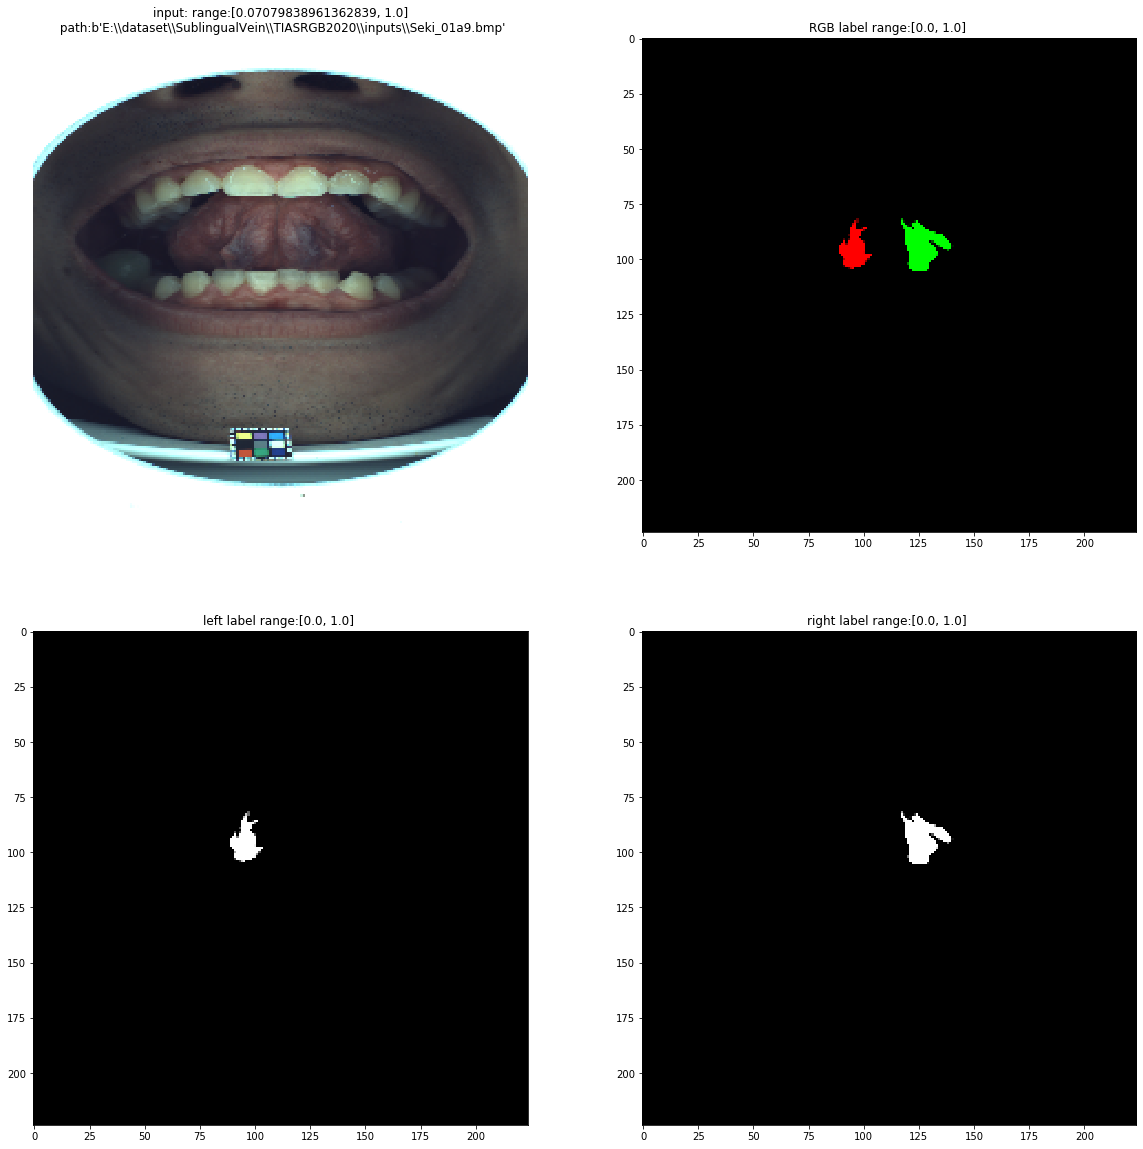

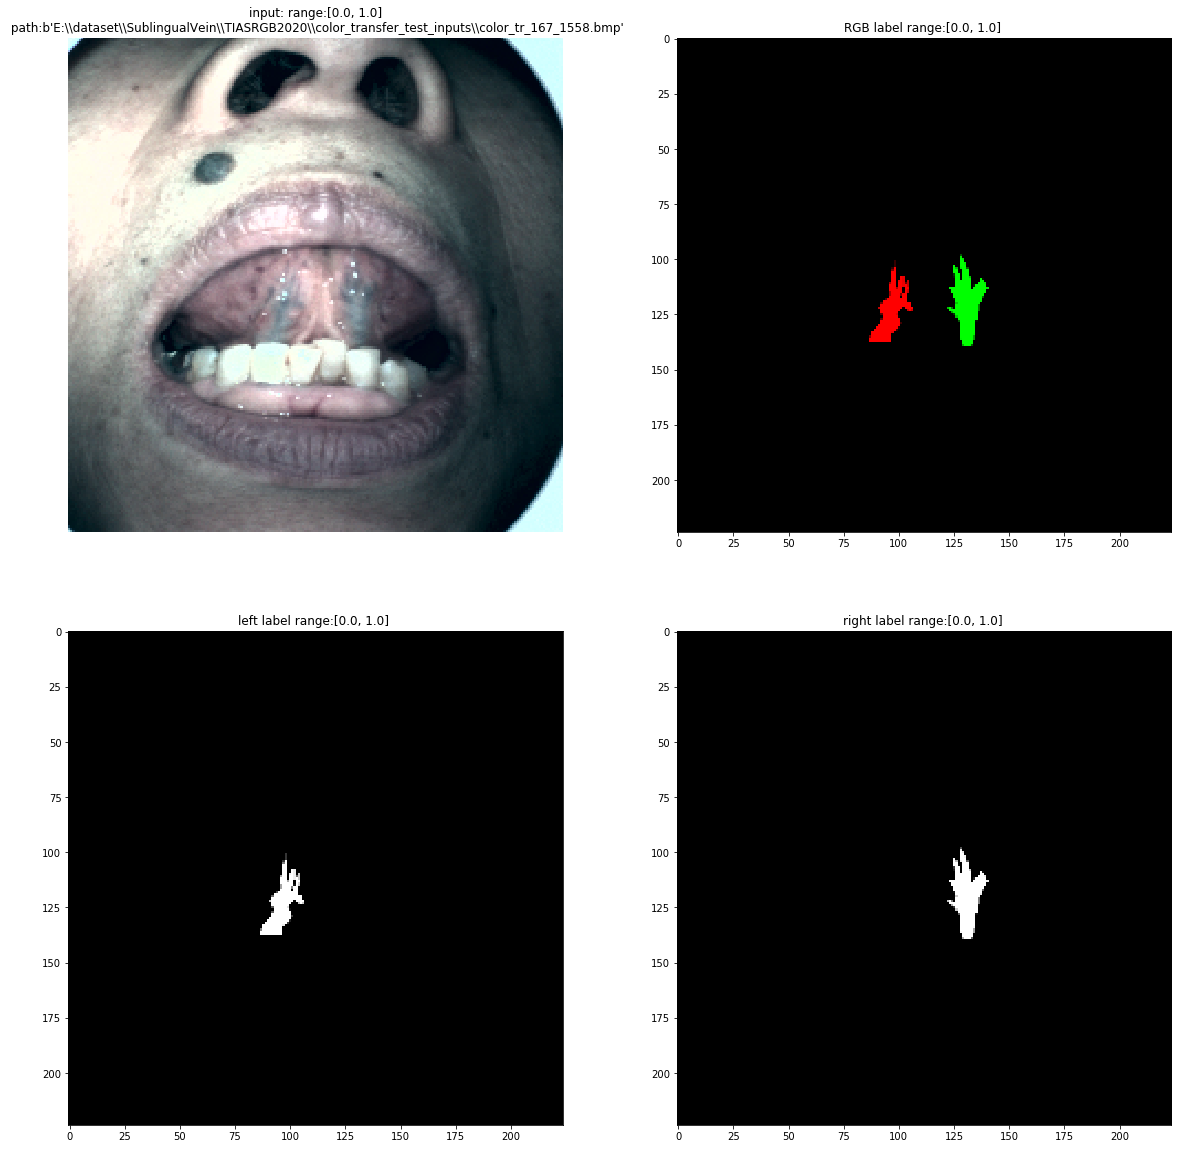

In [4]:
##  pre-processing funcs define
# # check the dataset
def plot_input_and_mask(img, concat_maskss, image_path):
#     palette = copy(plt.cm.gray)
#     palette.set_over('r', 1.0)
#     print("dicom_path:", dicom_path)
    print("image_path:", image_path)
    print("input_image.shape", img.numpy().shape)
    print("seg_labels.shape", concat_maskss.numpy().shape)

    fig, axes = plt.subplots(2,2, figsize=(20,20))
    
    print()
    axes[0,0].imshow(img)
    axes[0,0].set_title('input: range:[{}, {}]\n path:{}'.format((np.min(img)), np.max(img), image_path))
    axes[0,0].axis('off')
    
    # change concat mask with different colors for the different channe， let the channel0 mask to R CHANNEL; CHANNEL 1 MASK TO BE G CHENNEL;
    # NEED TO CONCAT ONE MORE ZEORS CHANNEL WITH THE SAME SHAPE AS EACH MASK CHANNEL
    blue_channel = np.zeros((concat_maskss.shape[0], concat_maskss.shape[1],1))
    print("blue channel.shape:", blue_channel.shape)
    rgb_masks = np.concatenate((concat_maskss,blue_channel), axis=-1)
    axes[0, 1].set_title('RGB label range:[{}, {}] '.format(np.min(rgb_masks), np.max(rgb_masks)))
    axes[0,1].imshow(rgb_masks)
    
    axes[1, 0].imshow(concat_maskss[:,:,0], cmap='gray')
    axes[1, 0].set_title('left label range:[{}, {}] '.format(np.min(concat_maskss[:,:,0]), np.max(concat_maskss[:,:,0])))
#     axes[1, 0].axis('off')
    axes[1, 1].imshow(concat_maskss[:,:,1], cmap='gray')
    axes[1, 1].set_title('right label range:[{}, {}] '.format(np.min(concat_maskss[:,:,1]), np.max(concat_maskss[:,:,1])))
#     axes[1, 1].axis('off')

def decode_img(img_bytes, img_type="bmp"):
    # conver compuresed string to a 3D unit8 tensor
    if img_type == "bmp":
        img = tf.io.decode_bmp(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # this will nomrlize within (0 , max)
    else:
        img =tf.io.decode_png(img_bytes, channels=1)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.

    # resize the image to the desired size.
    return tf.image.resize(img, [img_h, img_w])  # A 1-D int32 Tensor of 2 elements: new_height, new_width. The new size for the images.
    
def label_norm(label):
    label= label/255.0
#     print("label range: [{}, {}] ".format(np.min(label.numpy()), np.max(label.numpy())))
    return label
    
    
def load_image(image_path, img_type = "bmp"):
    img_bytes = tf.io.read_file(image_path)
    decoded_img = decode_img(img_bytes, img_type)
    return decoded_img

@tf.function
def train_process_func(image_path, left_mask_path, right_mask_path):
    # load input
    inputs =  load_image(image_path, "bmp")
    print("inputs shape:", inputs.shape)
    # load mask 
    left_masks = load_image(left_mask_path, "png")
    right_masks = load_image(right_mask_path, "png")
    left_masks =  label_norm(left_masks)
    right_masks =  label_norm(right_masks)
    print("left_masks shape:", left_masks.shape)
    print("right_masks shape:", right_masks.shape)
    
 
    if tf.random.uniform(()) > 0.5:
        inputs = tf.image.flip_left_right(inputs)
        left_masks = tf.image.flip_left_right(left_masks)
        right_masks = tf.image.flip_left_right(right_masks)
        concat_masks = tf.concat([right_masks, left_masks], axis=-1)
        # need to swap green and red channel
#         r, g, b =  tf.split(masks, 3, axis=-1)
    else:
        concat_masks = tf.concat([left_masks, right_masks], axis=-1) # concat last dimension so the mask shape [w, h, 2]; left:0 ; right :1
    print("concat_masks shape:", concat_masks.shape)
#         masks =  tf.concat([g, r, b], axis=-1)
        
    return inputs, concat_masks, image_path

@tf.function
def test_process_func(image_path, left_mask_path, right_mask_path):
    # load input
    inputs =  load_image(image_path, "bmp")
    print("inputs shape:", inputs.shape)
      # load mask 
    left_masks = load_image(left_mask_path, "png")
    right_masks = load_image(right_mask_path, "png")
    left_masks =  label_norm(left_masks)
    right_masks =  label_norm(right_masks)
    print("left_masks shape:", left_masks.shape)
    print("right_masks shape:", right_masks.shape)
    
    concat_masks = tf.concat([left_masks, right_masks], axis=-1) # concat last dimension so the mask shape [w, h, 2]; left:0 ; right :1
    print("concat_masks shape:", concat_masks.shape)
#         masks =  tf.concat([g, r, b], axis=-1)
    return inputs, concat_masks, image_path


# genrate dataset from dataset paths
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_left_masks, train_right_masks))       
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_left_masks, test_right_masks))  


print("")
# for data in train_dataset.take(1):
#     print(data[0])
#     print(data[1])

train_dataset = train_dataset.shuffle(300)

# train_dataset = train_dataset.map(map_func=train_process_func,
#                                   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE).repeat()    #
train_dataset = train_dataset.map(map_func=train_process_func,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)  # if use for lop directly on the dataset no repeat()

test_dataset = test_dataset.map(map_func=test_process_func,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)   


# check the train image
for inputs, concat_masks, image_path in train_dataset.take(1):
    print("input shpae:", inputs.shape)
    print("concat_masks:", concat_masks.shape)
    plot_input_and_mask(inputs[0],concat_masks[0] ,image_path[0])
#     fig2, axes2 = plt.subplots(1,1, figsize=(8,8))
#     axes2.hist( masks[0].numpy().reshape((-1)), bins= 20)
#     axes2.set_title('seg range:[{}, {}] '.format(np.min( masks[0]), np.max( masks[0])))
    
for inputs, concat_masks, image_path in test_dataset.take(1):
    print("input shpae:", inputs.shape)
    print("concat_masks:", concat_masks.shape)
    plot_input_and_mask(inputs[0],concat_masks[0], image_path[0])

## model design

In [5]:
# BASE MODEL

base_model = tf.keras.applications.MobileNetV2(input_shape=[img_h, img_w, 3], include_top=False)
# tf.keras.utils.plot_model(base_model, to_file="base_MobileNetV2.png", show_shapes=True, dpi=64)

layers: [<tf.Tensor 'block_1_expand_relu/Identity:0' shape=(None, 112, 112, 96) dtype=float32>, <tf.Tensor 'block_3_expand_relu/Identity:0' shape=(None, 56, 56, 144) dtype=float32>, <tf.Tensor 'block_6_expand_relu/Identity:0' shape=(None, 28, 28, 192) dtype=float32>, <tf.Tensor 'block_13_expand_relu/Identity:0' shape=(None, 14, 14, 576) dtype=float32>, <tf.Tensor 'block_16_project/Identity:0' shape=(None, 7, 7, 320) dtype=float32>]


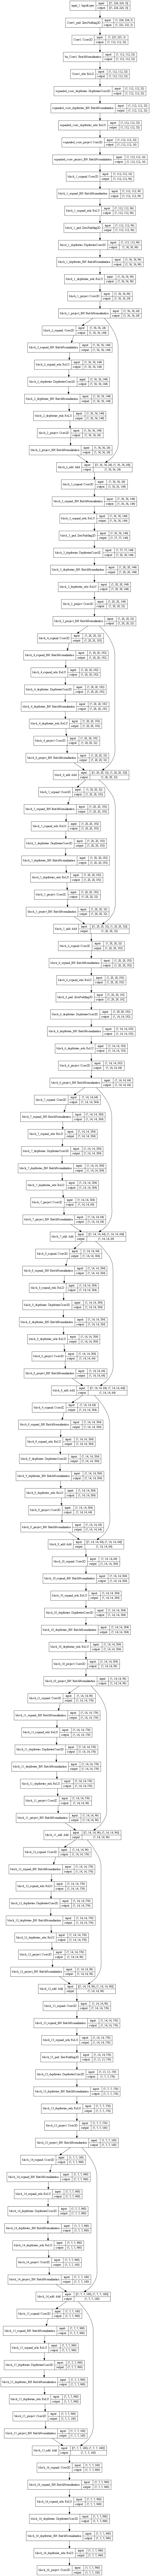

In [6]:
# Use the activations of these layers. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
print('layers:', layers)

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = True
tf.keras.utils.plot_model(down_stack, to_file="down_stack.png", show_shapes=True, dpi=64)

In [7]:
# The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.
from tensorflow.keras.layers import Lambda, Dense

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
          tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]


# def gram_matrix(features, normalize=True):
#     """ Compute the Gram matrix from features. Inputs: - features: Tensor of shape (1, H, W, C) giving features for a single image. - normalize: optional, whether to normalize the Gram matrix If True, divide the Gram matrix by the number of neurons (H * W * C) Returns: - gram: Tensor of shape (C, C) giving the (optionally normalized) Gram matrices for the input image. """
#     shape = tf.shape(features)
#     features_reshaped = tf.reshape(features, (shape[1]*shape[2], shape[3]))
#     gram = tf.matmul(tf.transpose(features_reshaped), features_reshaped)
#     if normalize:
#         gram /= tf.cast((shape[3] * shape[1] * shape[2]), tf.float32)
#     return gram

# def style_loss(feats, q_extracted_style_layers, i_extracted_style_layers):
#     """ Computes the style loss at a set of layers. Inputs: - feats: list of the features at every layer of the current image, as produced by the extract_features function. - style_layers: List of layer indices into feats giving the layers to include in the style loss. - style_targets: List of the same length as style_layers, where style_targets[i] is a Tensor giving the Gram matrix the source style image computed at layer style_layers[i]. - style_weights: List of the same length as style_layers, where style_weights[i] is a scalar giving the weight for the style loss at layer style_layers[i]. Returns: - style_loss: A Tensor contataining the scalar style loss. """
#     total_loss = 0.0
#     for i in range(len(q_extracted_style_layers)):
#         q_layer_features = q_extracted_style_layers[i]
#         i_layer_feautres =  i_extracted_style_layers[i]
#         A = gram_matrix(feats[style_layers[i]])
#         total_loss += style_weights[i]*tf.reduce_sum((G - A)**2)

#     return total_loss

# def euclidean_distance(vects):
#     x, y = vects
#     sum_square =tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
# #     return tf.math.sqrt(K.maximum(sum_square, tf.keras.backend.epsilon()))
#     return tf.math.sqrt(K.maximum(sum_square, tf.keras.backend.epsilon()))
#     return tf.math.sqrt(sum_square)

# def feature_extraction():
#     query_input = tf.keras.layers.Input(shape=[img_h, img_w,3])
#     train_input = tf.keras.layers.Input(shape=[img_h, img_w,3])
#     skips_query = down_stack(x_q)
#     print("skips_query", skips_query)
#     skips_input = down_stack(x_i)
#     print("skips_input", skips_input)
#     return  tf.keras.Model(inputs=[query_input, train_input], skips_input=[skips_input, skips_query]) 

# feature_extractor = feature_extraction() 
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[img_h, img_w, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)
    
    x =  tf.sigmoid(x)
  
    

        
    
    
#     x =  tf.sigmoid(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

One_shot_MobileNetV2UNet = unet_model(OUTPUT_CHANNELS)
# tf.keras.utils.plot_model(One_shot_MobileNetV2UNet, to_file="One_shot_MobileNetV2UNet.png", show_shapes=True, dpi=64)



In [8]:
# check feature extractor
# tf.keras.utils.plot_model(feature_extractor, to_file="feature_extractor.png", show_shapes=True, dpi=64)

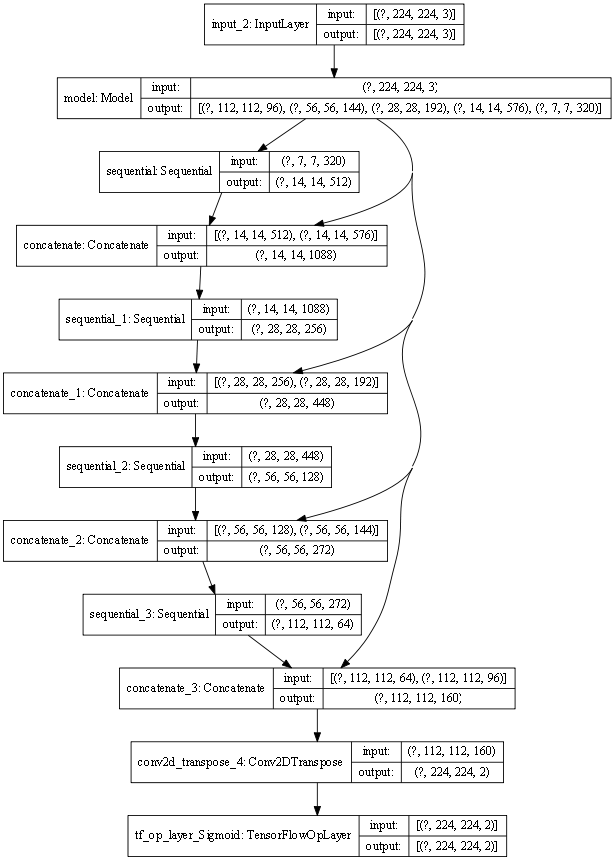

In [9]:
# check entire model
tf.keras.utils.plot_model(One_shot_MobileNetV2UNet, to_file="One_shot_MobileNetV2UNet.png", show_shapes=True, dpi=64)
#

## prepare training

In [10]:
# project_name
project_name = "NEW_BASE_UNET_1Input_TestColorTran_SmoothL1/"
if not os.path.exists(project_name):
    os.makedirs(project_name)
# tb_log_name 
log_dir=project_name + "AE_logs/"

# image_save name
train_save_figure_path = project_name + "AE_saves/train"
test_save_figure_path = project_name + "AE_saves/test"

# training_checkpoint name
checkpoint_dir = project_name + "training_checkpoints"

# -------------------------------------------------------------------------->

## get current working directory
cwd = os.getcwd()
print("current working directory:", cwd)
train_full_AE_saves =  os.path.join(cwd, train_save_figure_path)
test_full_AE_saves =  os.path.join(cwd, test_save_figure_path)
print("train_full_AE_saves:", train_full_AE_saves)
print("test_full_AE_saves:", test_full_AE_saves)


if not os.path.exists(train_full_AE_saves):
    os.makedirs(train_full_AE_saves)

if not os.path.exists(test_full_AE_saves):
    os.makedirs(test_full_AE_saves)
    
    
train_predictions_save_path =os.path.join(train_full_AE_saves, "Predictions")
# train_clsDistr_save_path =os.path.join(train_full_AE_saves, "ClassDistruibution")

test_predictions_save_path =os.path.join(test_full_AE_saves, "Predictions")

# test_confusion_matrix =  os.path.join(test_full_AE_saves, "Confusion_Matrix")
# test_cm_diags =  os.path.join(test_full_AE_saves, "Confusion_Matrix_diagnoise_with_Epoch")

# test_batch_losses =  os.path.join(test_full_AE_saves, "Test_batch_losses")

test_EpochValidation_save_path =os.path.join(test_full_AE_saves, "EpochValidation")
# test_EpochValidation_save_path_pred =os.path.join(test_EpochValidation_save_path, "PredictionsOnly")
if not os.path.exists(train_predictions_save_path):
    os.makedirs(train_predictions_save_path)
# if not os.path.exists(train_clsDistr_save_path):
#     os.makedirs(train_clsDistr_save_path)
    
if not os.path.exists(test_predictions_save_path):
    os.makedirs(test_predictions_save_path)
if not os.path.exists(test_EpochValidation_save_path):
    os.makedirs(test_EpochValidation_save_path)
# if not os.path.exists(test_EpochValidation_save_path_pred):
#     os.makedirs(test_EpochValidation_save_path_pred)   
# if not os.path.exists(test_confusion_matrix):
#     os.makedirs(test_confusion_matrix)       
# if not os.path.exists(test_cm_diags):
#     os.makedirs(test_cm_diags) 
# if not os.path.exists(test_batch_losses):
#     os.makedirs(test_batch_losses)   
    
#     plt.show()

# 
import datetime

# for tensorboard writers
datetime_rec =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary_writer = tf.summary.create_file_writer(
  log_dir + "train")
val_summary_writer = tf.summary.create_file_writer(
  log_dir + "val")

%reload_ext tensorboard
%tensorboard --logdir {log_dir}

current working directory: E:\Projects\TF2\SublingualVein\2020May
train_full_AE_saves: E:\Projects\TF2\SublingualVein\2020May\NEW_BASE_UNET_1Input_TestColorTran_Dice/AE_saves/train
test_full_AE_saves: E:\Projects\TF2\SublingualVein\2020May\NEW_BASE_UNET_1Input_TestColorTran_Dice/AE_saves/test


Reusing TensorBoard on port 6006 (pid 4872), started 2:34:38 ago. (Use '!kill 4872' to kill it.)

In [11]:
# design new loss for the new model as new_train_step, new_test_step
# new_optimizer =  tf.keras.optimizers.Adam(1e-4)
# from tf.keras.utils import to_categorical
# BCE =  tf.keras.losses.BinaryCrossentropy() 
# Huber =  tf.keras.losses.Huber(delta=0.1)
# SCC = tf.keras.losses.SparseCategoricalCrossentropy()

# @tf.function
# def dice_coef(y_true, y_pred, smooth=1, input_type="RGB"):
# #     if input_type == "RGB":
# #         y_true =  tf.image.rgb_to_grayscale(y_true)
# #         y_pred = tf.image.rgb_to_grayscale(y_pred)
        
# #     else: pass
#     y_true =  tf.cast(tf.math.greater(y_true, 0), tf.float32)
#     y_pred =  tf.cast(tf.math.greater(y_pred, 0.5), tf.float32)
#     print("y_true.shape", y_true)
#     print("y_pred.shape",y_pred)
    
#     intersection = tf.math.reduce_sum(y_true * y_pred)
#     union = tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred)
#     dice = tf.reduce_mean((2. * intersection + smooth)/(union + smooth))
#     return dice

# @tf.function
# def iou_coef(y_true, y_pred, smooth=1):
#   intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
#   union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
#   iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
#   return iou

# @tf.function
def Smooth_l1_loss(labels,predictions):
    diff=tf.abs(labels-predictions)
    less_than_one=tf.cast(tf.less(diff,1.0),tf.float32)   #Bool to float32
    smooth_l1_loss=(less_than_one*0.5*diff**2)+(1.0-less_than_one)*(diff-0.5)#同上图公式
    return tf.reduce_mean(smooth_l1_loss)

# @tf.function
# def dice_loss(y_true, y_pred):
#     dice_loss =  1- dice_coef(y_true, y_pred)
#     return dice_loss

def dice_loss(y_true, y_pred):
#     print("[dice_loss] y_pred=",y_pred,"y_true=",y_true)
    y_true = tf.cast(y_true, tf.float32)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

@tf.function()
# define losses
def new_compute_loss(seg_truth, seg_pred):
    Dice_loss = dice_loss(seg_truth, seg_pred)
    dice = 1 - Dice_loss
    L1_Smooth_loss = Smooth_l1_loss(seg_truth, seg_pred)
    total_loss = L1_Smooth_loss

    return total_loss, dice
    

# @tf.function()
def new_train_step(model, optimizer, inputs, seg_target, training):
    with tf.GradientTape() as tape:  # very interesting

        seg_pred = model(inputs, training=training)
#         print(Upper_mean_feature_maps.shape)
        print(seg_pred.shape)
        total_loss, dice = new_compute_loss(seg_truth =seg_target, seg_pred= seg_pred)
#         dice = dice_coef(seg_target, seg_pred)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, seg_pred, dice

# @tf.function()
def new_test_step(model, inputs, seg_target, training):
    with tf.GradientTape() as tape:  # if use tf.function. needs to wrap the code with the same variable name otherwise non-first call value error
        seg_pred = model(inputs, training=training)
        total_loss, dice = new_compute_loss(seg_truth =seg_target, seg_pred= seg_pred)
#         dice = dice_coef(seg_target, seg_pred)
    return total_loss, seg_pred, dice

In [18]:
import matplotlib.gridspec as gridspec
def check_predictions(model, tr_element, epoch, batch, save =True, train=False):
    train_inputs =  tr_element[0]
    train_labels =  tr_element[1]
    train_paths =  tr_element[2]
    
    seg_predicts = model.predict(train_inputs)
    
    d_loss = dice_loss(train_labels, seg_predicts)
    print("d_loss:", d_loss)
    for i in range(train_inputs.shape[0]):
        
        print("model_outputs shape:", seg_predicts.shape)
    #         print("ed_loss:", ed_loss)
    #         print("mean_feature_maps shape:", mean_feature_maps.shape)

    #     print("class_sigmoid_output shape:", class_sigmoid_output)


        single_input =train_inputs[i].numpy()    
        single_target = train_labels[i].numpy()
        single_pred = seg_predicts[i] 
        
        blue_channel = np.zeros((single_target.shape[0], single_target.shape[1],1))
        print("blue channel.shape:", blue_channel.shape)
        single_RGB_target = np.concatenate((single_target,blue_channel), axis=-1)


        fig = plt.figure(figsize=(18, 12))
        gs = gridspec.GridSpec(nrows=4, ncols=2, height_ratios=[2, 1, 1, 2], width_ratios=[1, 1], left=0.3, bottom=0.1, right=0.7, top=0.95,
        wspace=0.0, hspace=0.5)
        ax0 = fig.add_subplot(gs[0, 0])  # for the input
        ax1 = fig.add_subplot(gs[0, 1])  # for RGB labels
        ax2 = fig.add_subplot(gs[1, 0])  # for left label
        ax3 = fig.add_subplot(gs[1, 1])  # for right label
        ax4 = fig.add_subplot(gs[2, 0])  # for predict left labbel
        ax5 = fig.add_subplot(gs[2, 1])  # for predicted right label
        ax6 = fig.add_subplot(gs[3:, :])  # for predicted rgb label
        

        print("single_input.shape", single_input.shape)
        print("single_target.shape", single_target.shape)

        ax0.imshow(single_input)
        ax0.set_title('single input range:\n[{:.4f}, {:.4f}]'.format(np.min(single_input), np.max(single_input)))
        
        ax1.imshow(single_RGB_target)
        ax1.set_title('single_RGB_target range:\n[{:.4f}, {:.4f}]'.format(np.min(single_RGB_target), np.max(single_RGB_target)))
        
        ax2.imshow(single_target[:,:, 0], cmap='gray')
        ax2.set_title('label left range:\n[{:.4f}, {:.4f}]'.format(np.min(single_target[:,:, 0]), np.max(single_target[:,:, 0])))
        
        ax3.imshow(single_target[:,:, 1], cmap='gray')
        ax3.set_title('label rights range:\n[{:.4f}, {:.4f}]'.format(np.min(single_target[:,:, 1]), np.max(single_target[:,:, 1])))
        
        ax4.imshow(single_pred[:,:, 0], cmap='gray')
        ax4.set_title('pred left range:\n[{:.4f}, {:.4f}]'.format(np.min(single_pred[:,:, 0]), np.max(single_pred[:,:, 0])))
        
        ax5.imshow(single_pred[:,:, 1], cmap='gray')
        ax5.set_title('pred right range:\n[{:.4f}, {:.4f}]'.format(np.min(single_pred[:,:, 1]), np.max(single_pred[:,:, 1])))
        
        # prdeicted_RGB
        predicted_RGB_target = np.concatenate((single_pred,blue_channel), axis=-1)
        ax6.imshow(predicted_RGB_target)
        ax6.set_title('pred RGB range:\n[{:.4f}, {:.4f}]\n dice:{}'.format(np.min(predicted_RGB_target), np.max(predicted_RGB_target), 1-d_loss))

        plt.tight_layout()
        if save==True :
            if train:
                fig.savefig(train_save_figure_path + "/Train_image_at_epoch_{:04d}_batch_{}_idx_{}.png".format(epoch, batch, i))  
            else:
                fig.savefig(test_EpochValidation_save_path + "/Test_image_at_epoch_{:04d}_batch_{}_idx_{}.png".format(epoch, batch, i)) 
        plt.show()
  
    
#     if save==True :
#         if Train_or_not:
#             fig.savefig(train_save_figure_path + "/Train_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
#         else:
#             if Epoch_val:
#                 fig.savefig(test_EpochValidation_save_path + "/Test_image_at_epoch_{:04d}_batch_{}_idx.png".format(epoch,batch_idx))
#             else:
#                 fig.savefig(test_save_figure_path + "/Test_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
     
    
#     plt.show()
    
# def test_predict_all_images(model, batch_input, batch_seg_target, epoch): 
#     for i in range(batch_seg_target.shape[0]):
#         check_mean_feature_images(model, batch_input, batch_seg_target, epoch, i, save =True, train=False)


In [19]:
# for final_element in final_train_dataset.take(1):
#     tr_input =  final_element[0][0]
#     tr_label =  final_element[0][1]
#     tr_query =  final_element[1]
#     print("tr_input.shape:", tr_input.shape)
#     # check the feature extractor
#     input_extracted_features = down_stack.predict(tr_input)
#     query_extracted_features = down_stack.predict(tr_query)
    
# #     check_predict_images(One_shot_MobileNetV2UNet, [tr_input, tr_query], tr_label, 1, 1, save=False, Train_or_not=True, Epoch_val =False)

d_loss: tf.Tensor(0.99827474, shape=(), dtype=float32)
model_outputs shape: (4, 224, 224, 2)
blue channel.shape: (224, 224, 1)
single_input.shape (224, 224, 3)
single_target.shape (224, 224, 2)


E:\Projects\Intepreters\Anaconda\envs\TF21\lib\site-packages\ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


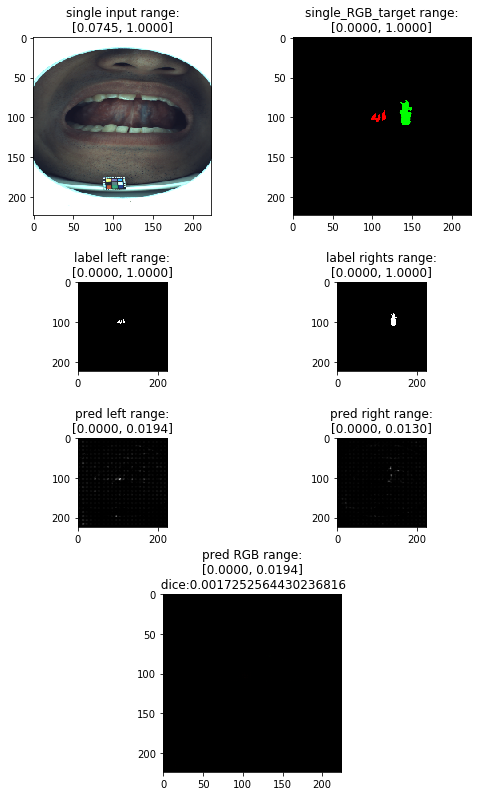

model_outputs shape: (4, 224, 224, 2)
blue channel.shape: (224, 224, 1)
single_input.shape (224, 224, 3)
single_target.shape (224, 224, 2)


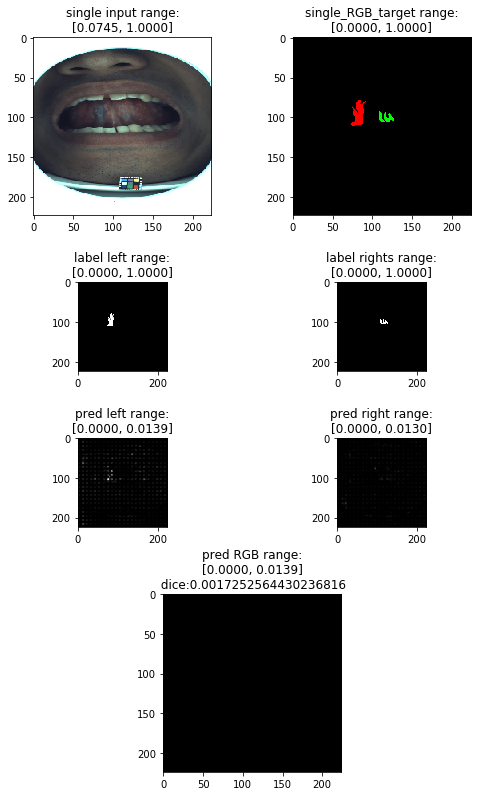

model_outputs shape: (4, 224, 224, 2)
blue channel.shape: (224, 224, 1)
single_input.shape (224, 224, 3)
single_target.shape (224, 224, 2)


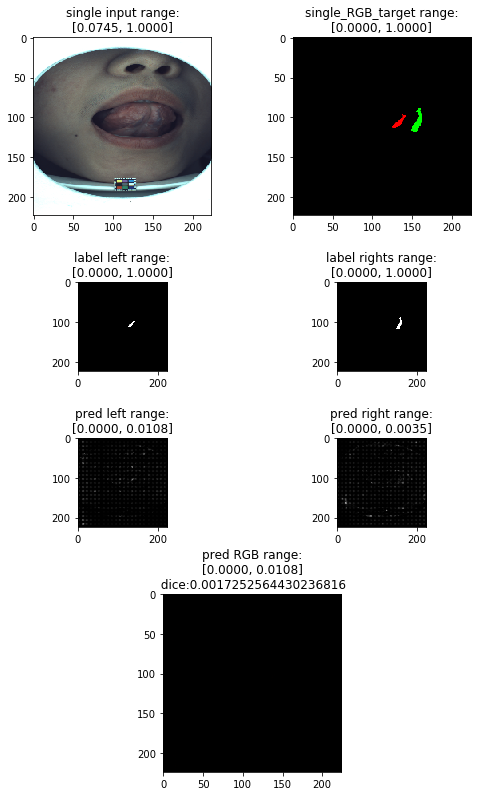

model_outputs shape: (4, 224, 224, 2)
blue channel.shape: (224, 224, 1)
single_input.shape (224, 224, 3)
single_target.shape (224, 224, 2)


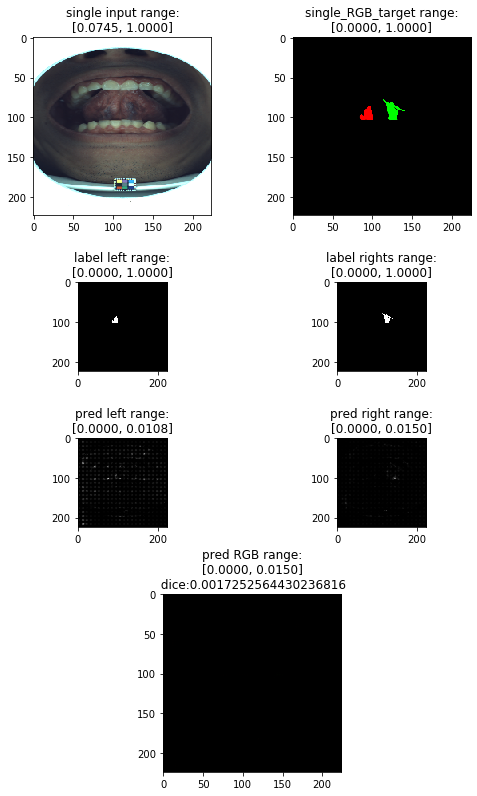

In [20]:
for tr_elements in train_dataset.take(1):
   
    check_predictions(One_shot_MobileNetV2UNet,tr_elements, 1, 1, save=False)

In [15]:
def write_single_total_loss_tb(writer, avg_losses, name, epoch):
    """
     avg_losses = [total_loss, seg_loss, cls_loss]
    """
    with writer.as_default():
        print("writing "+name +" logs to tensorboard...")                                                       
        # write scalars to the tensorboard after each train step
        tf.summary.scalar(name, avg_losses.result(), step=epoch)
        
def write_single_scalar_tb(writer, avg_losses, name, epoch):
    """
     avg_losses = [total_loss, seg_loss, cls_loss]
    """
    with writer.as_default():
        print("writing "+ name +" logs to tensorboard...s")                                                       
        # write scalars to the tensorboard after each train step
        tf.summary.scalar(name, avg_losses, step=epoch)
        
def train_display_save_at(model, tr_elements,   step, epoch, freq_step =200, save=True, Train_or_not=True):
    if step % freq_step ==0:
        print("train image checking----------------------------------------------------------------------------------->")
        check_predictions(model,tr_elements, epoch, step, save=True, train = Train_or_not )
#         check_predict_images(model, batch_inputs, batch_labels,  step, epoch, pred, save=save, Train_or_not=Train_or_not, Epoch_val =False)
        
def test_at_each_epoch(val_dataset, model, step, epoch, temp_dice, global_count_test, save=True, training=False):
    # initialize 
#     epoch_val_flag = True
    # initialize for evaluating average metric
    test_total_loss_mean = tf.keras.metrics.Mean()
    test_total_dice_mean = tf.keras.metrics.Mean()
#     test_total_ed_loss_mean = tf.keras.metrics.Mean()
#     manual_avg_dice = []
    count = 0
    for te_final_element in val_dataset:
        te_inputs =  te_final_element[0]
        te_labels =  te_final_element[1]
        te_paths =  te_final_element[2]
        
        # one train step loss calculation and optimization  model2, inputs, cls_target, training
        te_total_loss, _, te_dice = new_test_step(model, te_inputs, te_labels, training=False)
        test_total_loss_mean(te_total_loss)
        test_total_dice_mean(te_dice)
#         test_total_ed_loss_mean(te_ed_loss)
#         test_loss_catches.append(te_total_loss)

        count+=1
        print('[Test]Epoch: {} batch:{} \n  total_loss(dice_loss) loss: {}'.
              format(epoch, count, test_total_loss_mean.result()))
        
        if global_count_test %25 ==0:
            display.clear_output(wait=True)
        
        
        check_predictions(model, te_final_element, epoch, count, save=True, train = False )
    
    
#     # write logs to tensorboard:    avg_losses = [total_loss, seg_loss, cls_loss]
#     # write test losses to the tensorboard
    print("writing test logs to tensorboard...") 
    write_single_total_loss_tb(val_summary_writer, test_total_loss_mean, "total_loss_per_epoch", epoch)
    write_single_total_loss_tb(val_summary_writer, test_total_dice_mean, "Avg_dice_per_epoch", epoch)
    
    print("temp_dice:", temp_dice.numpy())
    if test_total_dice_mean.result() > temp_dice:
        save_path =  new_manager.save(checkpoint_number=epoch) # save the checkpoint and return the save path
        print("Saved checkpoint for epoch {}-  step {}: {}".format(epoch, step, save_path))
        temp_dice.assign(test_total_dice_mean.result())


# defin one epoch training for different dataset
def train_one_epoch(train_dataset, model, optimizer, step, epoch):
    #  initializations at each epoch 
    train_total_loss_mean = tf.keras.metrics.Mean()
    train_total_dice_mean = tf.keras.metrics.Mean()
#     train_total_ed_loss_mean = tf.keras.metrics.Mean()
    
    for tr_final_element in train_dataset:
        tr_input =  tr_final_element[0]
        tr_label =  tr_final_element[1]
        tr_path =  tr_final_element[2]
 
        # one train step loss calculation and optimization
        tr_total_loss, _ ,tr_dice = new_train_step(model, optimizer, tr_input, tr_label, training=True)
        train_total_loss_mean(tr_total_loss)
        train_total_dice_mean(tr_dice)  # this data is under the mode of train mode with input training dataset

        
        if optimizer.iterations.numpy() % 10 == 0: 
#             write_single_total_loss_tb(train_summary_writer, train_total_loss_mean, "train_total_loss_per_batch", optimizer.iterations.numpy())
            write_single_scalar_tb(train_summary_writer,  optimizer._decayed_lr(var_dtype=tf.float32), "Optimizer Lr", optimizer.iterations.numpy())
#             write_single_scalar_tb(train_summary_writer,  train_total_dice_mean.result(), "tr_Dice", optimizer.iterations.numpy())
#             write_single_scalar_tb(train_summary_writer,  train_total_ed_loss_mean.result(), "tr_ed_loss", optimizer.iterations.numpy())
        print('Epoch: {} batch:{} \n Train total_loss(dice_loss): {}'.
              format(epoch, int(step), train_total_loss_mean.result()))
        
        #  the saved figure is the prediction with test model with input training dataset
        train_display_save_at(model, tr_final_element,  int(step), epoch, freq_step =20, save=True, Train_or_not=True) 

        if step % 25 ==0:
            display.clear_output(wait=True)


        step.assign_add(1)
        
    
     # write train epoch average loss to the tensorboard
    print("writing train logs to tensorboard...") 
    write_single_total_loss_tb(train_summary_writer, train_total_loss_mean, "total_loss_per_epoch", epoch)
    write_single_total_loss_tb(train_summary_writer, train_total_dice_mean, "Avg_dice_per_epoch", epoch)
#     write_single_total_loss_tb(train_summary_writer, train_total_ed_loss_mean, "Avg_ed_loss_per_epoch", epoch)

In [16]:
# take_new_train_batches =  3035
def train_process(train_dataset, val_dataset, model, optimizer, step, start_epoch,global_test_step, global_dice_temp, total_epochs):
    # some initial parameters
    # test average_loss = for saving the test results
#     test_avg_tmp_dice =1
#     global_count_test = 1
    for epoch in range(int(start_epoch), total_epochs+1):
      
    
        # train one epoch， including loss calculation and optimization
        train_one_epoch(train_dataset, model, optimizer, step, epoch)
        
        # one training epoch ended start to evaluate the performance through entire test dataset
        test_at_each_epoch(val_dataset, model, int(step), epoch, temp_dice=global_dice_temp, global_count_test=global_test_step ,save=True, training = False)
      
      
        # when epoch fisnihed add epoch counter and reset the batch step 
        start_epoch.assign_add(1)     
        step.assign(1)
        
        
    # when training finihsed
    print("training finished") 

## train model

(4, 224, 224, 2)
Epoch: 4 batch:51 
 Train total_loss(dice_loss): 0.24182899296283722
(4, 224, 224, 2)
Epoch: 4 batch:52 
 Train total_loss(dice_loss): 0.24119833111763
(4, 224, 224, 2)
Epoch: 4 batch:53 
 Train total_loss(dice_loss): 0.24009989202022552
(4, 224, 224, 2)
Epoch: 4 batch:54 
 Train total_loss(dice_loss): 0.2398798018693924
(3, 224, 224, 2)
writing Optimizer Lr logs to tensorboard...s
Epoch: 4 batch:55 
 Train total_loss(dice_loss): 0.2418312430381775
writing train logs to tensorboard...
writing total_loss_per_epoch logs to tensorboard...
writing Avg_dice_per_epoch logs to tensorboard...
[Test]Epoch: 4 batch:1 
  total_loss(dice_loss) loss: 0.9964428544044495
d_loss: ()
model_outputs shape: (3, 224, 224, 2)
blue channel.shape: (224, 224, 1)
single_input.shape (224, 224, 3)
single_target.shape (224, 224, 2)


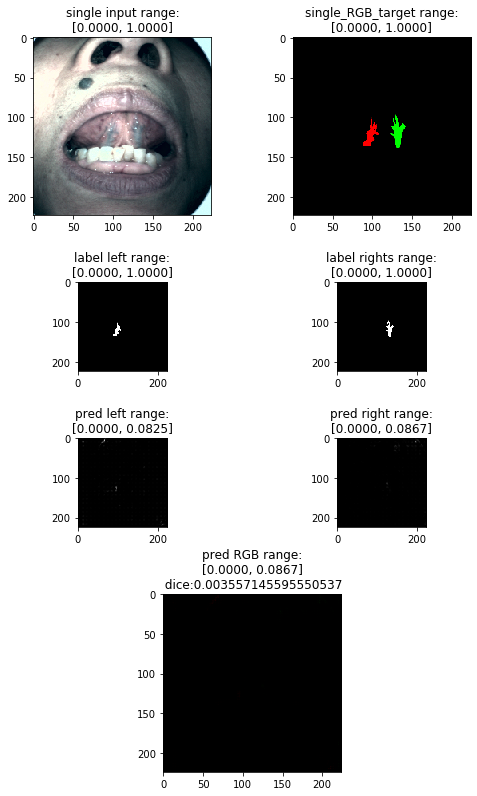

model_outputs shape: (3, 224, 224, 2)
blue channel.shape: (224, 224, 1)
single_input.shape (224, 224, 3)
single_target.shape (224, 224, 2)


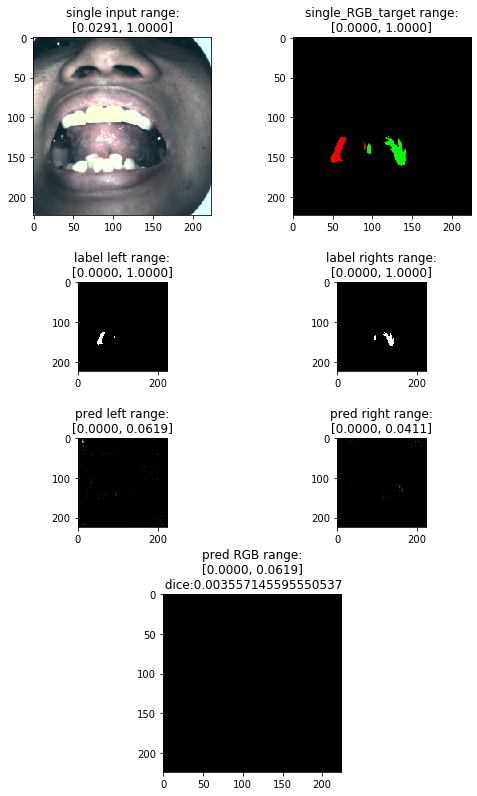

model_outputs shape: (3, 224, 224, 2)
blue channel.shape: (224, 224, 1)
single_input.shape (224, 224, 3)
single_target.shape (224, 224, 2)


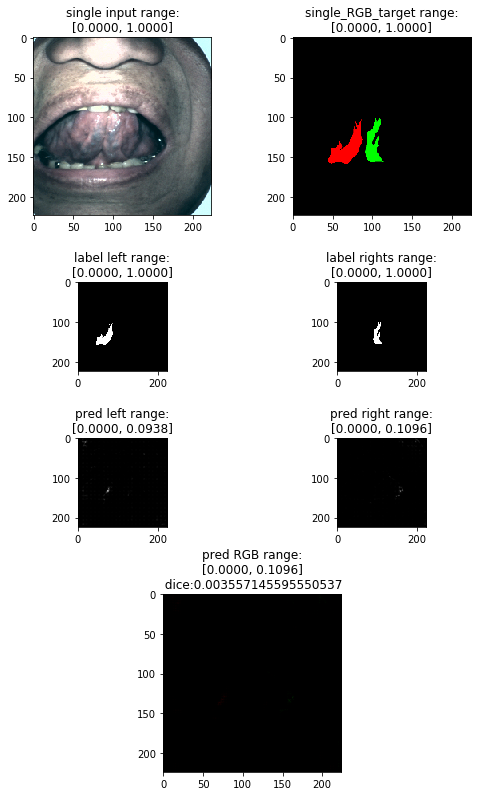

writing test logs to tensorboard...
writing total_loss_per_epoch logs to tensorboard...
writing Avg_dice_per_epoch logs to tensorboard...
temp_dice: 0.0
(4, 224, 224, 2)
Epoch: 5 batch:1 
 Train total_loss(dice_loss): 0.2725211977958679
(4, 224, 224, 2)
Epoch: 5 batch:2 
 Train total_loss(dice_loss): 0.2685515284538269
(4, 224, 224, 2)
Epoch: 5 batch:3 
 Train total_loss(dice_loss): 0.2561355233192444
(4, 224, 224, 2)
Epoch: 5 batch:4 
 Train total_loss(dice_loss): 0.25151532888412476
(4, 224, 224, 2)
Epoch: 5 batch:5 
 Train total_loss(dice_loss): 0.2412322759628296
(4, 224, 224, 2)
Epoch: 5 batch:6 
 Train total_loss(dice_loss): 0.24649697542190552
(4, 224, 224, 2)
Epoch: 5 batch:7 
 Train total_loss(dice_loss): 0.24649953842163086
(4, 224, 224, 2)
Epoch: 5 batch:8 
 Train total_loss(dice_loss): 0.2457045614719391
(4, 224, 224, 2)
Epoch: 5 batch:9 
 Train total_loss(dice_loss): 0.23796221613883972
(4, 224, 224, 2)
writing Optimizer Lr logs to tensorboard...s
Epoch: 5 batch:10 
 Train

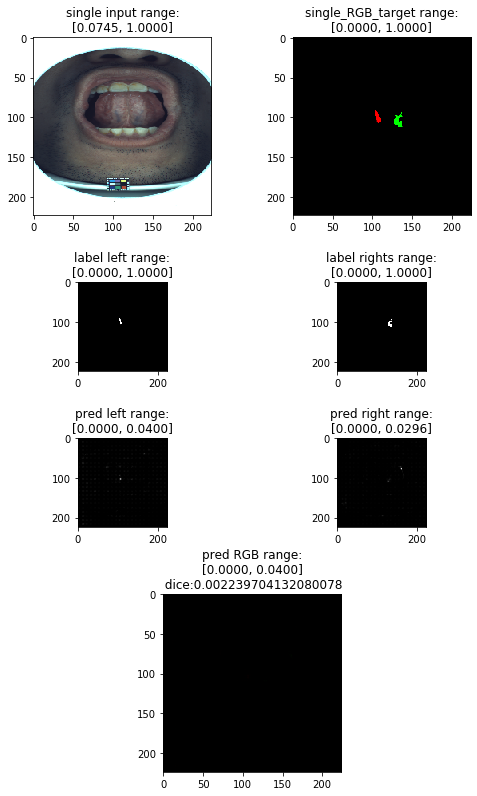

model_outputs shape: (4, 224, 224, 2)
blue channel.shape: (224, 224, 1)
single_input.shape (224, 224, 3)
single_target.shape (224, 224, 2)


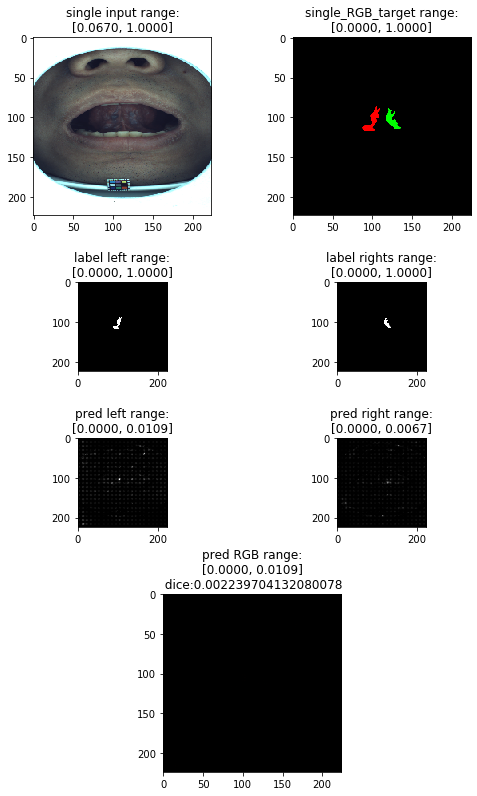

model_outputs shape: (4, 224, 224, 2)
blue channel.shape: (224, 224, 1)
single_input.shape (224, 224, 3)
single_target.shape (224, 224, 2)


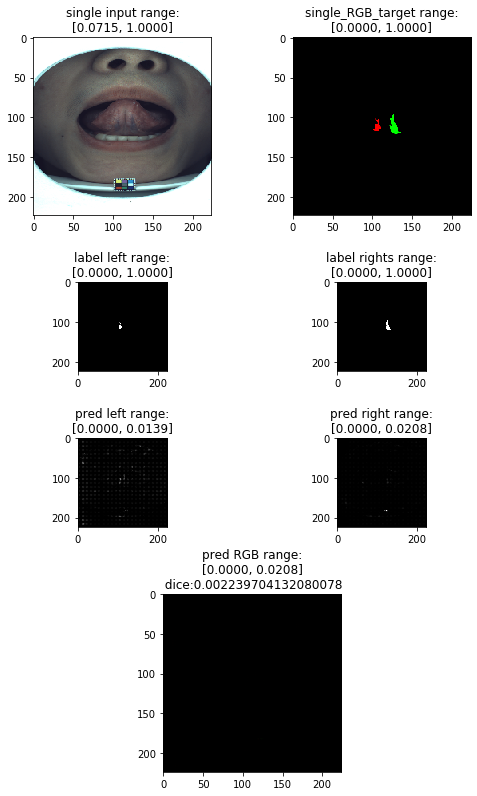

model_outputs shape: (4, 224, 224, 2)
blue channel.shape: (224, 224, 1)
single_input.shape (224, 224, 3)
single_target.shape (224, 224, 2)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "E:\Projects\Intepreters\Anaconda\envs\TF21\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-3fa3440c0ca9>", line 42, in <module>
    train_process(train_dataset, test_dataset, model, optimizer, step, ckpt_epoch, global_test_step, global_dice_temp, total_epochs=epochs)
  File "<ipython-input-16-7df9c805f938>", line 11, in train_process
    train_one_epoch(train_dataset, model, optimizer, step, epoch)
  File "<ipython-input-15-732afc662658>", line 97, in train_one_epoch
    train_display_save_at(model, tr_final_element,  int(step), epoch, freq_step =20, save=True, Train_or_not=True)
  File "<ipython-input-15-732afc662658>", line 22, in train_display_save_at
    check_predictions(model,tr_elements, epoch, step, save=True, train = Train_or_not )
  File "<ipython-input-12-e313ca437a8c>", line 73, in check_predictions
    plt.show()
  File "E:\

KeyboardInterrupt: 

In [17]:
import time
if __name__ == "__main__":
    
    init_lr = 5e-4
    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=init_lr,
      decay_steps=10000,
      end_learning_rate=0.00005)
#     learning_rate_fn = 1e-3
    new_optimizer =  tf.keras.optimizers.Adam(learning_rate_fn)
    # build_new check point manager
    new_ckpt_prefix = os.path.join(checkpoint_dir, "ckpt")
    if not os.path.exists(new_ckpt_prefix):
        os.makedirs(new_ckpt_prefix)
    #  contents of states to be saved as attributes on the checkpoint object
    new_ckpt_ob = tf.train.Checkpoint(step= tf.Variable(1),
                                      epoch=  tf.Variable(1),
                                      global_test_step =  tf.Variable(1),
                                      global_dice_temp =  tf.Variable(0.0),
                                        optimizer=new_optimizer,
                                         model =  One_shot_MobileNetV2UNet
                                     )
    # define checkpoint manager
    new_manager =  tf.train.CheckpointManager(new_ckpt_ob, new_ckpt_prefix, max_to_keep=1)

    # check the whether there is a checkpoint in the checkpoint folder, if it is restore from it
    if new_manager.latest_checkpoint:
        print("Restored from {}".format(new_manager.latest_checkpoint))
        new_ckpt_ob.restore(new_manager.latest_checkpoint)
    else:
        print("Initializing from scratch.")

    # reset checkcpoint.step for each epoch
    step =  new_ckpt_ob.step
    ckpt_epoch =  new_ckpt_ob.epoch  
    optimizer = new_ckpt_ob.optimizer
    model = new_ckpt_ob.model
    epochs = 1000
    global_test_step = new_ckpt_ob.global_test_step
    global_dice_temp = new_ckpt_ob.global_dice_temp
    # start train_process
    train_process(train_dataset, test_dataset, model, optimizer, step, ckpt_epoch, global_test_step, global_dice_temp, total_epochs=epochs)
